## Preparing the cleaned data for modelling

Import Statements

In [1]:
import pandas as pd
import numpy as np
from helper_functions import dataset_formatter
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

Read in the clean data

In [24]:
fire_data = pd.read_csv("./Data/clean_fire_data.csv", parse_dates=["MONTH"])
fire_data['FIPS_CODE'] = fire_data['FIPS_CODE'].astype(str).str.zfill(5)
fire_data['STATE_CODE'] = fire_data['FIPS_CODE'].str.slice(0, 2)

weather_data = pd.read_csv("./Data/cleaned_weather_data.csv", parse_dates=['MONTH'])
weather_data['STATE_CODE'] = weather_data['STATE_CODE'].astype(str).str.zfill(2)

In [25]:
min_month = min(fire_data['MONTH'])
max_month = max(fire_data['MONTH'])
print(f"Min: {min_month}")
print(f"Max: {max_month}")

Min: 1992-01-01 00:00:00
Max: 2018-12-01 00:00:00


Select the FIPS which we want to focus on, based on number of fires and total burn size or average burn ratio:

1. Napa County, CA - 06055
2. Maricopa County, AZ - 04013
3. San Diego County, CA - 06073
4. Elko County, NV - 32007
5. Powder River County, MT - 30075
6. Moffat County, CO - 08081
7. Riverside County, CA - 06065

Now create a function that will generate the dataset which we want to turn into the modelling dataset. 

The dataset structure which we are interested in is a monthly frequency time series dataset where we cover all months from our min_month to our max month. This way we have the same length of data regardless of the number of months for that county which did actually have a fire. We will utlize the total burn area as our variable to predict. We will utilize previous months total burn area, so that there is a time-lagged component. We will also utlize state and national total burn area as well in the time lagged components. Additionally, we have some monthly weather data on precipitation and high/low tempratures which will be included as regressors. 

In [26]:
napa_data = dataset_formatter('06055', fire_data, weather_data, min_month, max_month)
maricopa_data = dataset_formatter('04013', fire_data, weather_data, min_month, max_month)
san_diego_data = dataset_formatter('06073', fire_data, weather_data, min_month, max_month)
elko_data = dataset_formatter('32007', fire_data, weather_data, min_month, max_month)
powder_river_data = dataset_formatter('30075', fire_data, weather_data, min_month, max_month)
moffat_data = dataset_formatter('08081', fire_data, weather_data, min_month, max_month)
riverside_data = dataset_formatter('06065', fire_data, weather_data, min_month, max_month)

### Plotting the individual time series

These plots show that across the seven different counties we have a variety of severities of fires and a variety of frequencies of fires. This should give us a good sample on which to test our modelling framework. 

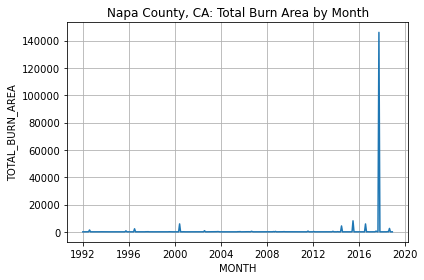

In [27]:
sns.lineplot(x='MONTH', y='TOTAL_BURN_AREA', data=napa_data)
plt.title("Napa County, CA: Total Burn Area by Month")
plt.grid()
plt.tight_layout()
plt.savefig("./img/NapaTimeSeriesPlot.png", dpi=300)
plt.show()

In [28]:
napa_data['PRCP'].describe()

count    324.000000
mean       1.848264
std        2.299875
min        0.007651
25%        0.215690
50%        0.852678
75%        2.693681
max       12.788833
Name: PRCP, dtype: float64

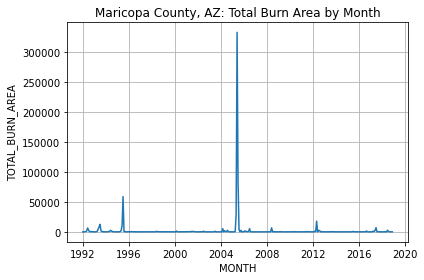

In [29]:
sns.lineplot(x='MONTH', y='TOTAL_BURN_AREA', data=maricopa_data)
plt.title("Maricopa County, AZ: Total Burn Area by Month")
plt.grid()
plt.tight_layout()
plt.savefig("./img/MaricopaTimeSeriesPlot.png", dpi=300)
plt.show()

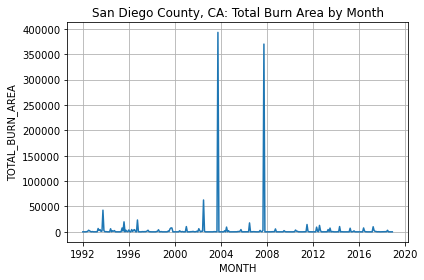

In [30]:
sns.lineplot(x='MONTH', y='TOTAL_BURN_AREA', data=san_diego_data)
plt.title("San Diego County, CA: Total Burn Area by Month")
plt.grid()
plt.tight_layout()
plt.savefig("./img/SanDiegoTimeSeriesPlot.png", dpi=300)
plt.show()

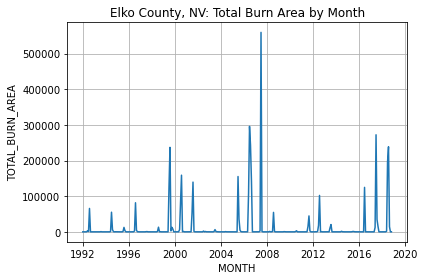

In [31]:
sns.lineplot(x='MONTH', y='TOTAL_BURN_AREA', data=elko_data)
plt.title("Elko County, NV: Total Burn Area by Month")
plt.grid()
plt.tight_layout()
plt.savefig("./img/ElkoTimeSeriesPlot.png", dpi=300)
plt.show()

In [32]:
napa_data['COUNTY_AREA'].describe()

count    3.240000e+02
mean     5.045376e+05
std      2.973182e-09
min      5.045376e+05
25%      5.045376e+05
50%      5.045376e+05
75%      5.045376e+05
max      5.045376e+05
Name: COUNTY_AREA, dtype: float64

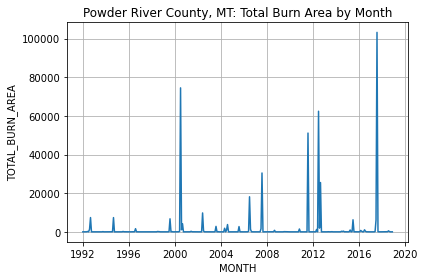

In [33]:
sns.lineplot(x='MONTH', y='TOTAL_BURN_AREA', data=powder_river_data)
plt.title("Powder River County, MT: Total Burn Area by Month")
plt.grid()
plt.tight_layout()
plt.savefig("./img/PowderRiverTimeSeriesPlot.png", dpi=300)
plt.show()

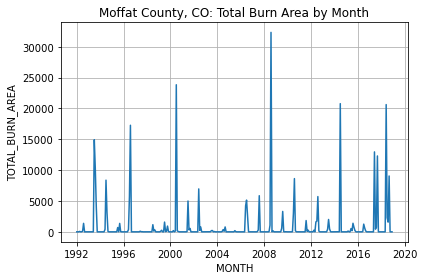

In [34]:
sns.lineplot(x='MONTH', y='TOTAL_BURN_AREA', data=moffat_data)
plt.title("Moffat County, CO: Total Burn Area by Month")
plt.grid()
plt.tight_layout()
plt.savefig("./img/MoffatTimeSeriesPlot.png", dpi=300)
plt.show()

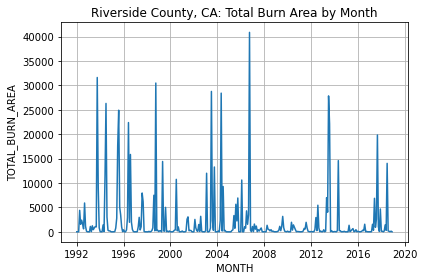

In [35]:
sns.lineplot(x='MONTH', y='TOTAL_BURN_AREA', data=riverside_data)
plt.title("Riverside County, CA: Total Burn Area by Month")
plt.grid()
plt.tight_layout()
plt.savefig("./img/RiversideTimeSeriesPlot.png", dpi=300)
plt.show()

### Plotting Time Series with Precipitation Data

In [36]:
def precip_plot(data, title: str = None, out_file: str = None):
    fig, ax1 = plt.subplots()
    ax1.plot(data['MONTH'], data['TOTAL_BURN_AREA'], label='Burn Area')
    ax1.legend(loc=1)
    ax1.set_ylabel("Burn Area (Acres)")
    ax1.set_xlabel("Month")

    ax2 = ax1.twinx()
    ax2.plot(data['MONTH'], data['PRCP'], color='red', label='Precipitation', linewidth=0.75)
    ax2.legend(loc=2)
    ax2.set_ylabel("Precipitation (In.)")

    plt.title(title)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"./img/{out_file}.png", dpi=300)
    plt.show()
    
def temp_plot(data, title: str = None, out_file: str = None):
    fig, ax1 = plt.subplots()
    ax1.plot(data['MONTH'], data['TOTAL_BURN_AREA'], label='Burn Area', color='black')
    ax1.legend(loc=1)
    ax1.set_ylabel("Burn Area (Acres)")
    ax1.set_xlabel("Month")

    ax2 = ax1.twinx()
    ax2.plot(data['MONTH'], data['TMIN'], color='blue', label='Min. Temp', linewidth=0.75)
    ax2.plot(data['MONTH'], data['TMAX'], color='red', label='Max. Temp', linewidth=0.75)
    ax2.legend(loc=2)
    ax2.set_ylabel("Temperature (Deg F)")

    plt.title(title)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"./img/{out_file}.png", dpi=300)
    plt.show()

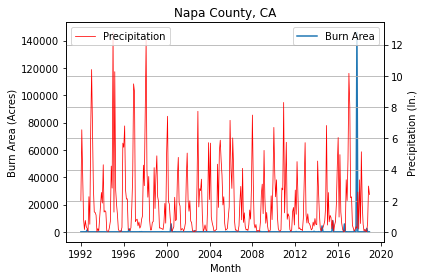

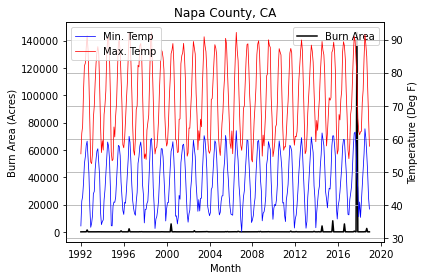

In [37]:
precip_plot(napa_data, title="Napa County, CA", out_file="NapaPrecipPlot")
temp_plot(napa_data, title="Napa County, CA", out_file="NapaTempPlot")

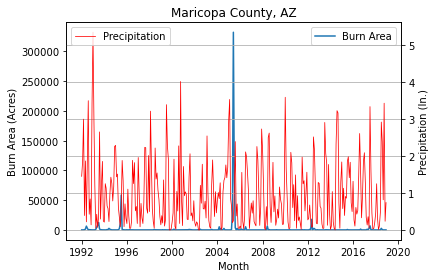

In [15]:
precip_plot(maricopa_data, title="Maricopa County, AZ", out_file="MaricopaPrecipPlot")

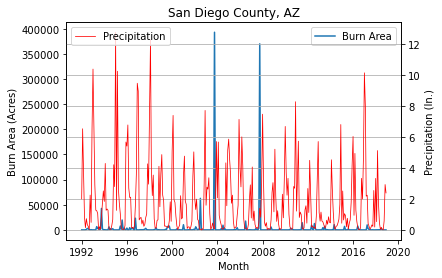

In [16]:
precip_plot(san_diego_data, title="San Diego County, AZ", out_file="SanDiegoPrecipPlot")

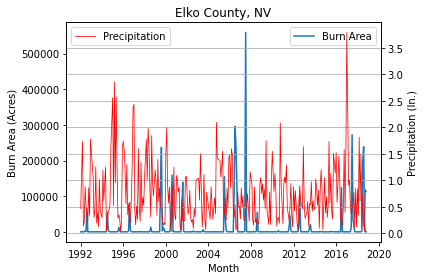

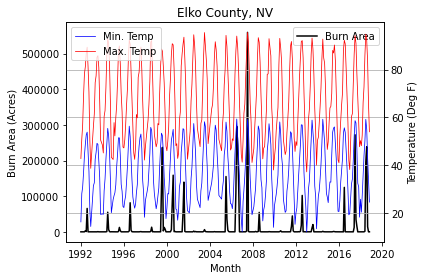

In [38]:
precip_plot(elko_data, title="Elko County, NV", out_file="ElkoPrecipPlot")
temp_plot(elko_data, title="Elko County, NV", out_file="ElkoTempPlot")

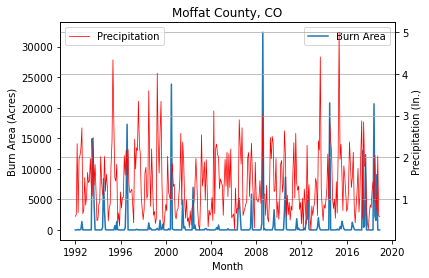

In [18]:

precip_plot(moffat_data, title="Moffat County, CO", out_file="MoffatPrecipPlot")

In [50]:
elko_data[['TOTAL_BURN_AREA', 'PRCP']].corr()

,TOTAL_BURN_AREA,PRCP
TOTAL_BURN_AREA,1.000000,-0.140673
PRCP,-0.140673,1.000000


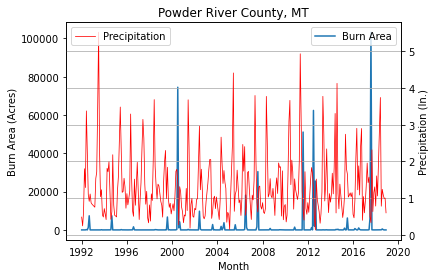

In [19]:
precip_plot(powder_river_data, title="Powder River County, MT", out_file="PowderRiverPrecipPlot")

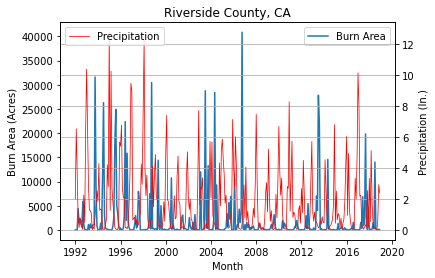

In [20]:
precip_plot(riverside_data, title="Riverside County, CA", out_file="RiversidePrecipPlot")

### Plot Auto-Correlation & Partial Auto-Correlation for Burn Area

Correlation is taken concurrently - i.e. for the same time period - compares month to month

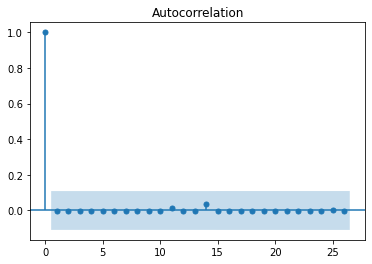

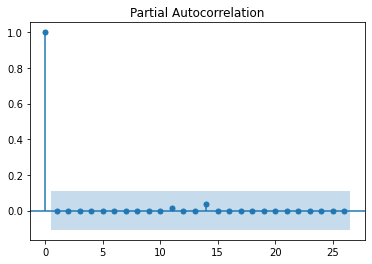

In [21]:
sm.graphics.tsa.plot_acf(napa_data['TOTAL_BURN_AREA'])
plt.show()

sm.graphics.tsa.plot_pacf(napa_data['TOTAL_BURN_AREA'])
plt.show()

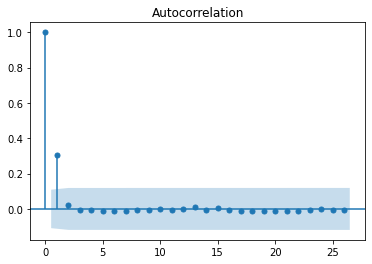

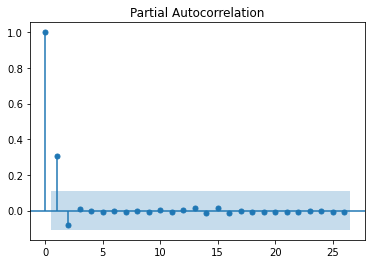

In [22]:
sm.graphics.tsa.plot_acf(maricopa_data['TOTAL_BURN_AREA'])
plt.show()

sm.graphics.tsa.plot_pacf(maricopa_data['TOTAL_BURN_AREA'])
plt.show()

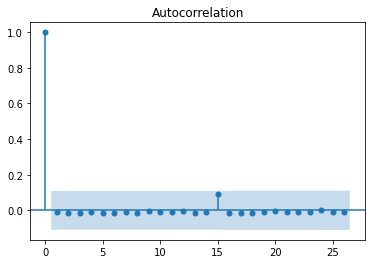

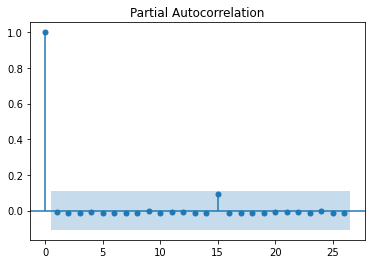

In [23]:
sm.graphics.tsa.plot_acf(san_diego_data['TOTAL_BURN_AREA'])
plt.show()

sm.graphics.tsa.plot_pacf(san_diego_data['TOTAL_BURN_AREA'])
plt.show()

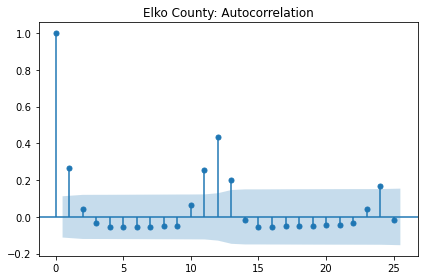

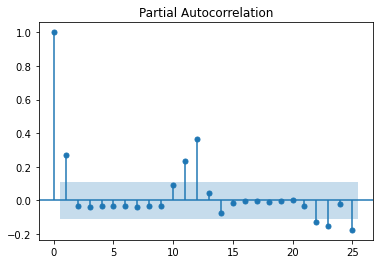

In [41]:
sm.graphics.tsa.plot_acf(elko_data['TOTAL_BURN_AREA'])
plt.tight_layout()
plt.title("Elko County: Autocorrelation")
plt.savefig('./img/ElkoACFPlot.png')
plt.show()

sm.graphics.tsa.plot_pacf(elko_data['TOTAL_BURN_AREA'])
plt.show()

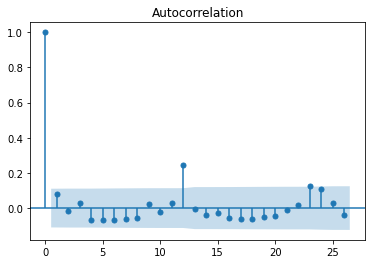

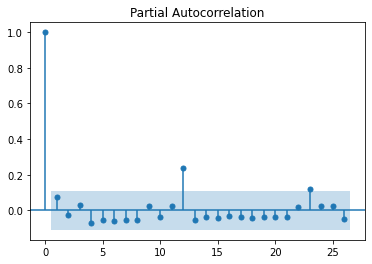

In [25]:
sm.graphics.tsa.plot_acf(moffat_data['TOTAL_BURN_AREA'])
plt.show()

sm.graphics.tsa.plot_pacf(moffat_data['TOTAL_BURN_AREA'])
plt.show()

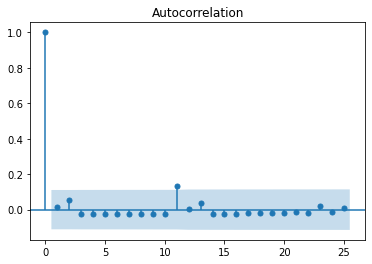

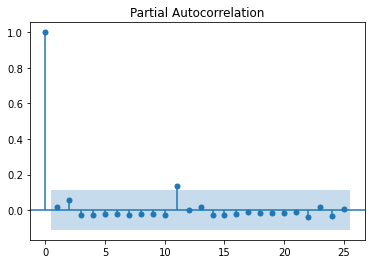

In [26]:
sm.graphics.tsa.plot_acf(powder_river_data['TOTAL_BURN_AREA'])
plt.show()

sm.graphics.tsa.plot_pacf(powder_river_data['TOTAL_BURN_AREA'])
plt.show()

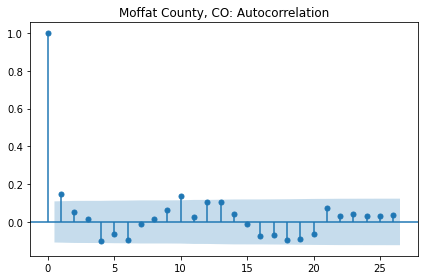

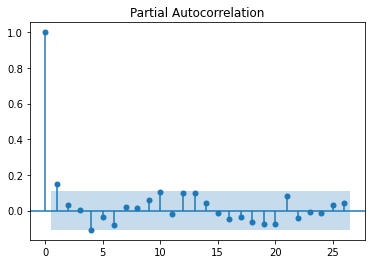

In [43]:
sm.graphics.tsa.plot_acf(riverside_data['TOTAL_BURN_AREA'])
plt.tight_layout()
plt.title("Moffat County, CO: Autocorrelation")
plt.savefig("./img/MoffatACFPlot.png", dpi=300)
plt.show()

sm.graphics.tsa.plot_pacf(riverside_data['TOTAL_BURN_AREA'])
plt.show()

### Plot of State's and National Burn Area

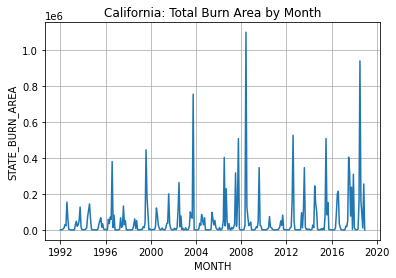

In [28]:
sns.lineplot(x='MONTH', y='STATE_BURN_AREA', data=napa_data)
plt.title("California: Total Burn Area by Month")
plt.grid()
plt.savefig("./img/CaliforniaTimeSeriesPlot.png", dpi=300)
plt.show()

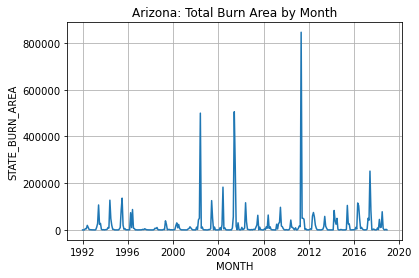

In [29]:
sns.lineplot(x='MONTH', y='STATE_BURN_AREA', data=maricopa_data)
plt.title("Arizona: Total Burn Area by Month")
plt.grid()
plt.savefig("./img/ArizonaTimeSeriesPlot.png", dpi=300)
plt.show()

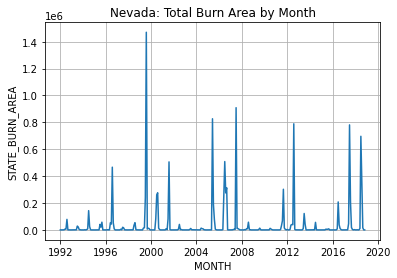

In [30]:
sns.lineplot(x='MONTH', y='STATE_BURN_AREA', data=elko_data)
plt.title("Nevada: Total Burn Area by Month")
plt.grid()
plt.savefig("./img/NevadaTimeSeriesPlot.png", dpi=300)
plt.show()

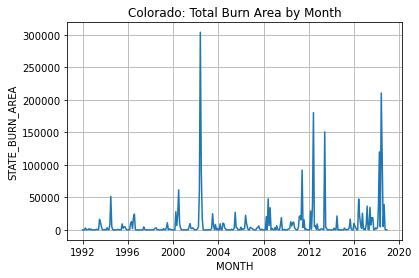

In [31]:
sns.lineplot(x='MONTH', y='STATE_BURN_AREA', data=moffat_data)
plt.title("Colorado: Total Burn Area by Month")
plt.grid()
plt.savefig("./img/ColoradoTimeSeriesPlot.png", dpi=300)
plt.show()

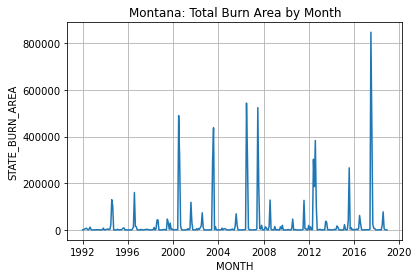

In [32]:
sns.lineplot(x='MONTH', y='STATE_BURN_AREA', data=powder_river_data)
plt.title("Montana: Total Burn Area by Month")
plt.grid()
plt.savefig("./img/MontanaTimeSeriesPlot.png", dpi=300)
plt.show()

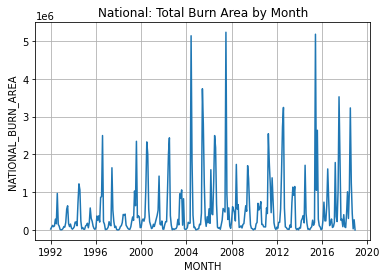

In [33]:
sns.lineplot(x='MONTH', y='NATIONAL_BURN_AREA', data=napa_data)
plt.title("National: Total Burn Area by Month")
plt.grid()
plt.savefig("./img/NationalTimeSeriesPlot.png", dpi=300)
plt.show()

### Plot of the ACF & PACF of Select Weather Data 

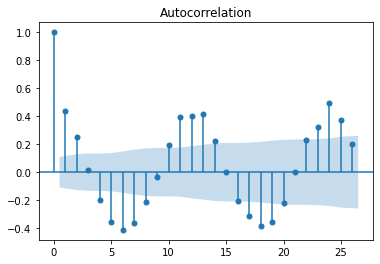

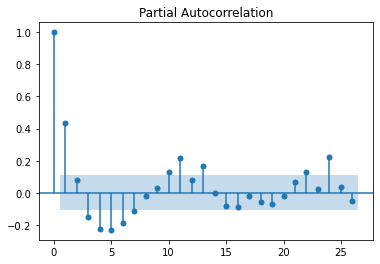

In [34]:
sm.graphics.tsa.plot_acf(napa_data['PRCP'])
plt.show()

sm.graphics.tsa.plot_pacf(napa_data['PRCP'])
plt.show()

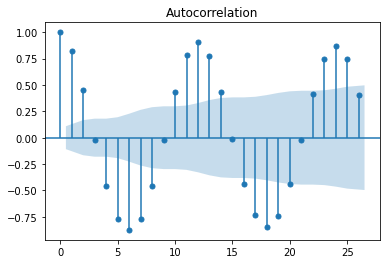

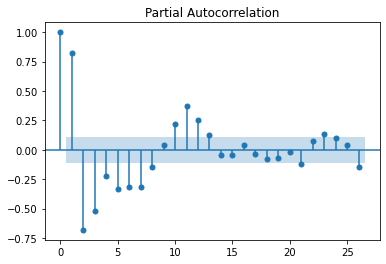

In [35]:
sm.graphics.tsa.plot_acf(napa_data['TMAX'])
plt.show()

sm.graphics.tsa.plot_pacf(napa_data['TMAX'])
plt.show()

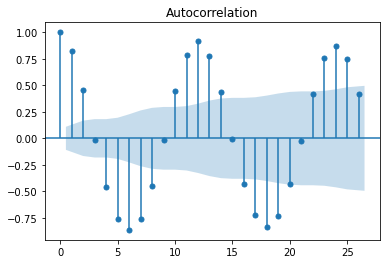

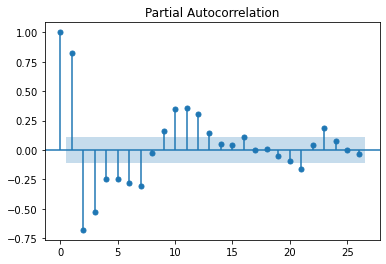

In [36]:
sm.graphics.tsa.plot_acf(napa_data['TMIN'])
plt.show()

sm.graphics.tsa.plot_pacf(napa_data['TMIN'])
plt.show()

In [94]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import plot
import sqlite3

In [4]:
cursor = sqlite3.connect('./Data/FPA_FOD_20210617.sqlite')
query = "SELECT f.* from Fires f"
all_data = pd.read_sql_query(query, cursor)

In [5]:
all_data.loc[:, 'DISCOVERY_DATE'] = pd.to_datetime(all_data.loc[:, 'DISCOVERY_DATE'].copy())
all_data['DISCOVERY_MONTH'] = all_data['DISCOVERY_DATE'].to_numpy().astype('datetime64[M]')

In [ ]:
fires_2018 = 

In [57]:
mo_data = all_data[all_data['DISCOVERY_MONTH'] >= '2018-01-01']

In [58]:
mo_data.columns

Index(['FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID',
       'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE',
       'NWCG_CAUSE_AGE_CATEGORY', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
       'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR',
       'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'DISCOVERY_MONTH'],
      dtype='object')

In [95]:
token = open("mapbox_token.txt").read()

fig = go.Figure()

fig = go.Figure(go.Densitymapbox(lat=mo_data.LATITUDE, lon=mo_data.LONGITUDE, z=mo_data.FIRE_SIZE,
                                 radius=10, colorbar=dict(title="Fire Size (Acres)"), colorscale=px.colors.sequential.Reds,
                                text=mo_data.FIRE_SIZE, hovertemplate="Location: (%{lat}, %{lon})<br>Fire Size: %{text}", 
                                 name=""))

fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token, 
                  mapbox_zoom=3.4, mapbox_center = {"lat": 38, "lon": -99})
fig.update_layout(title={'text':"All Fires: 2018", 'y':0.97, 'font':{'size': 24},
        'x':0.4,
        'xanchor': 'center',
        'yanchor': 'top'}, margin={"r":0,"t":50,"l":0,"b":0})
plot(fig, filename="./img/2018FireMap.html")


'./img/2018FireMap.html'